In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [1]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [2]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [3]:
# Import tqdm for progress bar construction
import tqdm

In [4]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [5]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
birdcsv_Path = 'C:\\Users\\ujubo\\bc_2021\\'
AudioImage_Path = 'C:\\Users\\ujubo\\bc_2021\\image\\'

In [6]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [14]:

birdcsv = pandas.read_csv(birdcsv_Path + 'metadata.csv')
birdcsv.loc[birdcsv['id'] >= 0, 'filepath'] = \
    AudioImage_Path + birdcsv.query('id >= 0')['primary_label'] + birdcsv.query('id >= 0')['filename'] + '.npy'


birdcsv = birdcsv.dropna()
birdcsv = birdcsv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
bird_dataframe = birdcsv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(bird_dataframe, bird_dataframe['id'])):
    bird_dataframe.loc[nth_groups, 'fold'] = int(n)

print(birdcsv.loc[birdcsv['id'] >= 0], 'filepath')

      primary_label                           secondary_labels  \
0            acafly                                 ['amegfi']   
1            acafly                                         []   
2            acafly                                         []   
3            acafly                                ['whwbec1']   
4            acafly                                ['whwbec1']   
...             ...                                        ...   
62869        yetvir                                         []   
62870        yetvir                                         []   
62871        yetvir  ['amered', 'eawpew', 'norcar', 'reevir1']   
62872        yetvir                                         []   
62873        yetvir                       ['gamqua', 'whwdov']   

                                                    type  latitude  longitude  \
0                   ['begging call', 'call', 'juvenile']   35.3860   -84.1250   
1                                            

In [171]:
# Hyper-parameters for training 
ff1010_batch = 32
birdclef_batch = 32

In [173]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.test_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        elif self.process == 'test':
            source = self.test_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

In [ ]:
# Class for birdclef dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

In [189]:
def evaluate_model(loader, model, beta=1.0):
  # TODO: extend this so that we can print that we evaluate test set.
  num_correct = 0
  num_samples = 0
  log_sum = 0
  fbeta_sum = 0
  model.eval()
  
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=torch.float)
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
      # In binary classification, it should be (batch size, 2) sized tensor

      # Checks naive accuracy.
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)

      # Checks Log Loss.
      # TODO: change this to F.cross_entropy()
      log_loss = F.nll_loss(F.log_softmax(scores), y)
      log_sum += log_loss.sum() * preds.size(0)

      # Checks Fbeta-score.
      fbeta = fbeta_score(preds, y, beta=beta)
      fbeta_sum += fbeta * preds.size(0)

    acc = float(num_correct) / num_samples
    log_score = log_sum / num_samples
    f_score = fbeta_sum / num_samples
    print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('Log Loss score:\t%.2f' % (log_score))
    print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
  return acc, log_score, f_score

In [190]:
# Print period for accuracy.
print_period = 12

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
#       (EDIT) It looks like we're ok with training.

model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device))
]))

print(model_1)

def train_model(model, train_loader, val_loader, test_loader, optimizer, beta=1.0, epoch=10):
    #accuracy
    val_losses = []
    train_losses = []
    test_losses = []
    #fbeta scores and log loss scores
    vlog_scores = []
    vfbeta_scores = []
    tlog_scores = []
    tfbeta_scores = []
    
    loss = 0
    log_score = 0
    
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores), y) # Log loss for our project.
            train_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))    
    
        print("\nChecking accuracy score on validation set.")
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        vlog_scores.append(log_score)
        vfbeta_scores.append(fbeta_score)
        
        print("\nChecking accuracy score on test set.")
        acc, log_score, fbeta_score = evaluate_model(test_loader, model, beta=beta)
        test_losses.append(acc)
        tlog_scores.append(log_score)
        tfbeta_scores.append(fbeta_score)
    
    return test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [191]:
from time import sleep

# Train loop for nocall detector
def nocall_train(train_dataframe, val_dataframe, test_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    test_data = FF1010(test_dataframe, process='test', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                             drop_last=False)
    
    
    optimizer = optim.SGD(model_1.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
    
    test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores = \
    train_model(model_1, train_loader, val_loader, test_loader, optimizer, beta=beta)
    
    
    return test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores

In [192]:
# Train, Validate and Test for nocall detector
def nocall(dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores = \
    nocall_train(train_dataframe, val_dataframe, test_dataframe)
    
    # TODO
    # 이쪽에 Accuracy test 구현하시면 됩니다.
    
    return test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores

In [193]:
test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores = \
nocall(ff1010_dataframe, 1, 0)

Training model 1, epoch 1


  0%|                                                                                          | 0/144 [00:00<?, ?it/s]C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/2557261719.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(scores), y) # Log loss for our project.
  1%|▌                                                                                 | 1/144 [00:03<09:12,  3.87s/it]

Iteration 0, loss = 0.5999


  9%|███████▎                                                                         | 13/144 [00:51<08:37,  3.95s/it]

Iteration 12, loss = 0.6967


 17%|██████████████                                                                   | 25/144 [01:38<07:51,  3.96s/it]

Iteration 24, loss = 0.7087


 26%|████████████████████▊                                                            | 37/144 [02:26<07:01,  3.94s/it]

Iteration 36, loss = 0.6630


 34%|███████████████████████████▌                                                     | 49/144 [03:13<06:16,  3.96s/it]

Iteration 48, loss = 0.4939


 42%|██████████████████████████████████▎                                              | 61/144 [04:00<05:28,  3.95s/it]

Iteration 60, loss = 0.5295


 51%|█████████████████████████████████████████                                        | 73/144 [04:48<04:40,  3.94s/it]

Iteration 72, loss = 0.6515


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:35<03:53,  3.95s/it]

Iteration 84, loss = 0.5622


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:23<03:04,  3.93s/it]

Iteration 96, loss = 0.5650


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [07:10<02:18,  3.97s/it]

Iteration 108, loss = 0.6391


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:58<01:30,  3.92s/it]

Iteration 120, loss = 0.6335


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:45<00:43,  3.94s/it]

Iteration 132, loss = 0.3751


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:28<00:00,  3.95s/it]



Checking accuracy score on validation set.


C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/2203863153.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_loss = F.nll_loss(F.log_softmax(scores), y)



Accuracy: 1160 / 1538 correct (75.42)
Log Loss score:	0.55
Fbeta-score (beta=1): 	0.75

Checking accuracy score on test set.

Accuracy: 1150 / 1538 correct (74.77)
Log Loss score:	0.55
Fbeta-score (beta=1): 	0.75
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:03<09:10,  3.85s/it]

Iteration 0, loss = 0.5331


  9%|███████▎                                                                         | 13/144 [00:49<08:22,  3.84s/it]

Iteration 12, loss = 0.4284


 17%|██████████████                                                                   | 25/144 [01:35<07:37,  3.85s/it]

Iteration 24, loss = 0.3402


 26%|████████████████████▊                                                            | 37/144 [02:21<06:49,  3.82s/it]

Iteration 36, loss = 0.5295


 34%|███████████████████████████▌                                                     | 49/144 [03:08<06:04,  3.84s/it]

Iteration 48, loss = 0.5759


 42%|██████████████████████████████████▎                                              | 61/144 [03:53<05:14,  3.78s/it]

Iteration 60, loss = 0.4960


 51%|█████████████████████████████████████████                                        | 73/144 [04:38<04:29,  3.79s/it]

Iteration 72, loss = 0.3598


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:24<03:42,  3.77s/it]

Iteration 84, loss = 0.2854


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:10<03:00,  3.84s/it]

Iteration 96, loss = 0.4827


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:56<02:14,  3.83s/it]

Iteration 108, loss = 0.3589


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:42<01:28,  3.84s/it]

Iteration 120, loss = 0.5134


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:28<00:42,  3.82s/it]

Iteration 132, loss = 0.5976


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:10<00:00,  3.83s/it]



Checking accuracy score on validation set.

Accuracy: 1275 / 1538 correct (82.90)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.83

Checking accuracy score on test set.

Accuracy: 1270 / 1538 correct (82.57)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.83
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:03<09:01,  3.79s/it]

Iteration 0, loss = 0.4859


  9%|███████▎                                                                         | 13/144 [00:49<08:20,  3.82s/it]

Iteration 12, loss = 0.3584


 17%|██████████████                                                                   | 25/144 [01:35<07:37,  3.84s/it]

Iteration 24, loss = 0.3433


 26%|████████████████████▊                                                            | 37/144 [02:21<06:49,  3.83s/it]

Iteration 36, loss = 0.4895


 34%|███████████████████████████▌                                                     | 49/144 [03:07<06:02,  3.82s/it]

Iteration 48, loss = 0.2898


 42%|██████████████████████████████████▎                                              | 61/144 [03:53<05:19,  3.85s/it]

Iteration 60, loss = 0.3229


 51%|█████████████████████████████████████████                                        | 73/144 [04:39<04:31,  3.82s/it]

Iteration 72, loss = 0.6606


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:25<03:47,  3.86s/it]

Iteration 84, loss = 0.3869


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:11<02:59,  3.83s/it]

Iteration 96, loss = 0.6492


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:57<02:14,  3.85s/it]

Iteration 108, loss = 0.4892


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:43<01:27,  3.80s/it]

Iteration 120, loss = 0.5178


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:29<00:42,  3.82s/it]

Iteration 132, loss = 0.4798


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:11<00:00,  3.83s/it]



Checking accuracy score on validation set.

Accuracy: 1302 / 1538 correct (84.66)
Log Loss score:	0.39
Fbeta-score (beta=1): 	0.85

Checking accuracy score on test set.

Accuracy: 1308 / 1538 correct (85.05)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:03<09:04,  3.81s/it]

Iteration 0, loss = 0.3938


  9%|███████▎                                                                         | 13/144 [00:49<08:21,  3.83s/it]

Iteration 12, loss = 0.2488


 17%|██████████████                                                                   | 25/144 [01:35<07:34,  3.82s/it]

Iteration 24, loss = 0.2972


 26%|████████████████████▊                                                            | 37/144 [02:21<06:52,  3.86s/it]

Iteration 36, loss = 0.2843


 34%|███████████████████████████▌                                                     | 49/144 [03:07<06:07,  3.86s/it]

Iteration 48, loss = 0.6520


 42%|██████████████████████████████████▎                                              | 61/144 [03:54<05:20,  3.86s/it]

Iteration 60, loss = 0.2570


 51%|█████████████████████████████████████████                                        | 73/144 [04:40<04:34,  3.87s/it]

Iteration 72, loss = 0.2990


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:26<03:46,  3.84s/it]

Iteration 84, loss = 0.3080


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:13<03:02,  3.87s/it]

Iteration 96, loss = 0.2744


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:59<02:14,  3.84s/it]

Iteration 108, loss = 0.5389


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:45<01:28,  3.84s/it]

Iteration 120, loss = 0.6535


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:31<00:42,  3.86s/it]

Iteration 132, loss = 0.3221


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:13<00:00,  3.85s/it]



Checking accuracy score on validation set.

Accuracy: 1306 / 1538 correct (84.92)
Log Loss score:	0.37
Fbeta-score (beta=1): 	0.85

Checking accuracy score on test set.

Accuracy: 1313 / 1538 correct (85.37)
Log Loss score:	0.38
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:03<09:04,  3.81s/it]

Iteration 0, loss = 0.2581


  9%|███████▎                                                                         | 13/144 [00:49<08:23,  3.84s/it]

Iteration 12, loss = 0.3410


 17%|██████████████                                                                   | 25/144 [01:35<07:36,  3.84s/it]

Iteration 24, loss = 0.3535


 26%|████████████████████▊                                                            | 37/144 [02:21<06:52,  3.85s/it]

Iteration 36, loss = 0.5120


 34%|███████████████████████████▌                                                     | 49/144 [03:08<06:07,  3.87s/it]

Iteration 48, loss = 0.1785


 42%|██████████████████████████████████▎                                              | 61/144 [03:54<05:19,  3.85s/it]

Iteration 60, loss = 0.4628


 51%|█████████████████████████████████████████                                        | 73/144 [04:40<04:30,  3.81s/it]

Iteration 72, loss = 0.2287


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:26<03:43,  3.79s/it]

Iteration 84, loss = 0.2198


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:11<02:57,  3.79s/it]

Iteration 96, loss = 0.2096


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:57<02:13,  3.80s/it]

Iteration 108, loss = 0.3321


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:42<01:27,  3.81s/it]

Iteration 120, loss = 0.1649


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:28<00:41,  3.81s/it]

Iteration 132, loss = 0.1908


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:10<00:00,  3.82s/it]



Checking accuracy score on validation set.

Accuracy: 1325 / 1538 correct (86.15)
Log Loss score:	0.36
Fbeta-score (beta=1): 	0.86

Checking accuracy score on test set.

Accuracy: 1314 / 1538 correct (85.44)
Log Loss score:	0.37
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:03<09:06,  3.82s/it]

Iteration 0, loss = 0.6576


  9%|███████▎                                                                         | 13/144 [00:49<08:22,  3.83s/it]

Iteration 12, loss = 0.4116


 17%|██████████████                                                                   | 25/144 [01:35<07:37,  3.85s/it]

Iteration 24, loss = 0.4256


 26%|████████████████████▊                                                            | 37/144 [02:21<06:49,  3.83s/it]

Iteration 36, loss = 0.5227


 34%|███████████████████████████▌                                                     | 49/144 [03:07<06:06,  3.86s/it]

Iteration 48, loss = 0.4563


 42%|██████████████████████████████████▎                                              | 61/144 [03:53<05:17,  3.83s/it]

Iteration 60, loss = 0.3136


 51%|█████████████████████████████████████████                                        | 73/144 [04:39<04:33,  3.85s/it]

Iteration 72, loss = 0.2786


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:25<03:46,  3.84s/it]

Iteration 84, loss = 0.2499


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:11<03:00,  3.84s/it]

Iteration 96, loss = 0.2254


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:57<02:14,  3.84s/it]

Iteration 108, loss = 0.3767


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:43<01:28,  3.84s/it]

Iteration 120, loss = 0.2030


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:29<00:42,  3.82s/it]

Iteration 132, loss = 0.3306


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:12<00:00,  3.84s/it]



Checking accuracy score on validation set.

Accuracy: 1344 / 1538 correct (87.39)
Log Loss score:	0.34
Fbeta-score (beta=1): 	0.87

Checking accuracy score on test set.

Accuracy: 1326 / 1538 correct (86.22)
Log Loss score:	0.36
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:03<09:02,  3.79s/it]

Iteration 0, loss = 0.5167


  9%|███████▎                                                                         | 13/144 [00:49<08:24,  3.85s/it]

Iteration 12, loss = 0.3320


 17%|██████████████                                                                   | 25/144 [01:35<07:34,  3.82s/it]

Iteration 24, loss = 0.3811


 26%|████████████████████▊                                                            | 37/144 [02:22<06:57,  3.90s/it]

Iteration 36, loss = 0.3646


 34%|███████████████████████████▌                                                     | 49/144 [03:09<06:09,  3.89s/it]

Iteration 48, loss = 0.2495


 42%|██████████████████████████████████▎                                              | 61/144 [03:54<05:18,  3.83s/it]

Iteration 60, loss = 0.2701


 51%|█████████████████████████████████████████                                        | 73/144 [04:41<04:37,  3.91s/it]

Iteration 72, loss = 0.4688


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:28<03:51,  3.92s/it]

Iteration 84, loss = 0.1940


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:14<02:58,  3.80s/it]

Iteration 96, loss = 0.4122


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [07:00<02:13,  3.81s/it]

Iteration 108, loss = 0.2215


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:45<01:27,  3.81s/it]

Iteration 120, loss = 0.5358


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:31<00:41,  3.82s/it]

Iteration 132, loss = 0.2108


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:13<00:00,  3.84s/it]



Checking accuracy score on validation set.

Accuracy: 1349 / 1538 correct (87.71)
Log Loss score:	0.34
Fbeta-score (beta=1): 	0.88

Checking accuracy score on test set.

Accuracy: 1328 / 1538 correct (86.35)
Log Loss score:	0.35
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:03<09:05,  3.82s/it]

Iteration 0, loss = 0.5741


  9%|███████▎                                                                         | 13/144 [00:49<08:17,  3.80s/it]

Iteration 12, loss = 0.3453


 17%|██████████████                                                                   | 25/144 [01:34<07:31,  3.79s/it]

Iteration 24, loss = 0.2229


 26%|████████████████████▊                                                            | 37/144 [02:20<06:45,  3.79s/it]

Iteration 36, loss = 0.2368


 34%|███████████████████████████▌                                                     | 49/144 [03:06<06:06,  3.85s/it]

Iteration 48, loss = 0.1400


 42%|██████████████████████████████████▎                                              | 61/144 [03:52<05:16,  3.81s/it]

Iteration 60, loss = 0.6044


 51%|█████████████████████████████████████████                                        | 73/144 [04:37<04:28,  3.77s/it]

Iteration 72, loss = 0.2774


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:23<03:45,  3.82s/it]

Iteration 84, loss = 0.3959


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:09<03:00,  3.83s/it]

Iteration 96, loss = 0.3937


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:55<02:13,  3.83s/it]

Iteration 108, loss = 0.2501


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:41<01:27,  3.82s/it]

Iteration 120, loss = 0.2405


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:26<00:41,  3.80s/it]

Iteration 132, loss = 0.2800


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:09<00:00,  3.81s/it]



Checking accuracy score on validation set.

Accuracy: 1349 / 1538 correct (87.71)
Log Loss score:	0.33
Fbeta-score (beta=1): 	0.88

Checking accuracy score on test set.

Accuracy: 1336 / 1538 correct (86.87)
Log Loss score:	0.35
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:03<08:57,  3.76s/it]

Iteration 0, loss = 0.2617


  9%|███████▎                                                                         | 13/144 [00:49<08:17,  3.80s/it]

Iteration 12, loss = 0.4358


 17%|██████████████                                                                   | 25/144 [01:34<07:26,  3.76s/it]

Iteration 24, loss = 0.3143


 26%|████████████████████▊                                                            | 37/144 [02:20<06:43,  3.77s/it]

Iteration 36, loss = 0.3182


 34%|███████████████████████████▌                                                     | 49/144 [03:05<05:57,  3.76s/it]

Iteration 48, loss = 0.3231


 42%|██████████████████████████████████▎                                              | 61/144 [03:50<05:10,  3.74s/it]

Iteration 60, loss = 0.4049


 51%|█████████████████████████████████████████                                        | 73/144 [04:35<04:32,  3.84s/it]

Iteration 72, loss = 0.2223


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:21<03:44,  3.81s/it]

Iteration 84, loss = 0.3225


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:06<02:57,  3.77s/it]

Iteration 96, loss = 0.1513


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:51<02:11,  3.75s/it]

Iteration 108, loss = 0.3768


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:37<01:26,  3.77s/it]

Iteration 120, loss = 0.1082


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:23<00:42,  3.83s/it]

Iteration 132, loss = 0.6303


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:04<00:00,  3.78s/it]



Checking accuracy score on validation set.

Accuracy: 1359 / 1538 correct (88.36)
Log Loss score:	0.32
Fbeta-score (beta=1): 	0.88

Checking accuracy score on test set.

Accuracy: 1330 / 1538 correct (86.48)
Log Loss score:	0.35
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:03<09:13,  3.87s/it]

Iteration 0, loss = 0.3900


  9%|███████▎                                                                         | 13/144 [00:49<08:17,  3.80s/it]

Iteration 12, loss = 0.3689


 17%|██████████████                                                                   | 25/144 [01:34<07:26,  3.75s/it]

Iteration 24, loss = 0.3143


 26%|████████████████████▊                                                            | 37/144 [02:19<06:43,  3.77s/it]

Iteration 36, loss = 0.1048


 34%|███████████████████████████▌                                                     | 49/144 [03:05<05:58,  3.77s/it]

Iteration 48, loss = 0.4842


 42%|██████████████████████████████████▎                                              | 61/144 [03:50<05:12,  3.77s/it]

Iteration 60, loss = 0.3760


 51%|█████████████████████████████████████████                                        | 73/144 [04:35<04:28,  3.78s/it]

Iteration 72, loss = 0.4415


 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:21<03:43,  3.79s/it]

Iteration 84, loss = 0.3672


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [06:06<02:56,  3.75s/it]

Iteration 96, loss = 0.2597


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [06:51<02:12,  3.80s/it]

Iteration 108, loss = 0.4483


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [07:37<01:27,  3.79s/it]

Iteration 120, loss = 0.2904


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [08:22<00:41,  3.76s/it]

Iteration 132, loss = 0.5175


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:03<00:00,  3.78s/it]



Checking accuracy score on validation set.

Accuracy: 1349 / 1538 correct (87.71)
Log Loss score:	0.32
Fbeta-score (beta=1): 	0.88

Checking accuracy score on test set.

Accuracy: 1336 / 1538 correct (86.87)
Log Loss score:	0.35
Fbeta-score (beta=1): 	0.87


C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

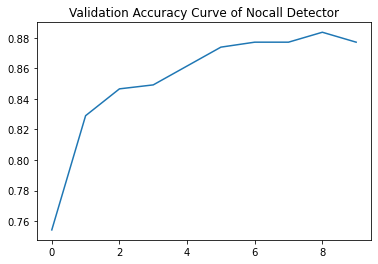

In [203]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/2813990176.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_losses = torch.tensor(test_losses, device = 'cpu')


Text(0.5, 1.0, 'Test Accuracy Curve of Nocall Detector')

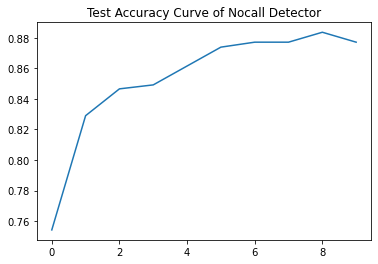

In [204]:
test_losses = torch.tensor(test_losses, device = 'cpu')
plt.plot(np.arange(len(test_losses)), val_losses)
plt.title('Test Accuracy Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/887383180.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vlog_scores = torch.tensor(vlog_scores, device = 'cpu')


Text(0.5, 1.0, 'Validation Log-score Curve of Nocall Detector')

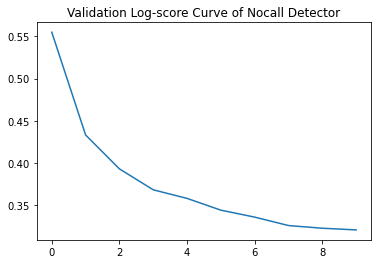

In [205]:
vlog_scores = torch.tensor(vlog_scores, device = 'cpu')
plt.plot(np.arange(len(vlog_scores)), vlog_scores)
plt.title('Validation Log-score Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/943193594.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vfbeta_scores = torch.tensor(vfbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'Validation F-beta score Curve of Nocall Detector')

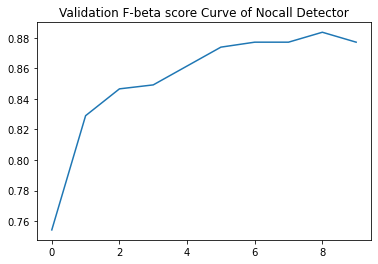

In [206]:
vfbeta_scores = torch.tensor(vfbeta_scores, device = 'cpu')
plt.plot(np.arange(len(vfbeta_scores)), vfbeta_scores)
plt.title('Validation F-beta score Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/839298986.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tlog_scores = torch.tensor(tlog_scores, device = 'cpu')


Text(0.5, 1.0, 'Test Log-score Curve of Nocall Detector')

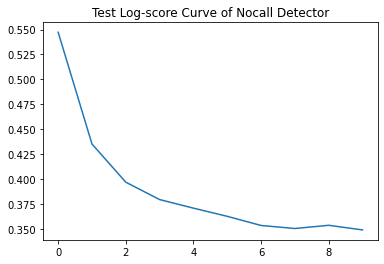

In [207]:
tlog_scores = torch.tensor(tlog_scores, device = 'cpu')
plt.plot(np.arange(len(tlog_scores)), tlog_scores)
plt.title('Test Log-score Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/1324963349.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tfbeta_scores = torch.tensor(tfbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'Test F-beta score Curve of Nocall Detector')

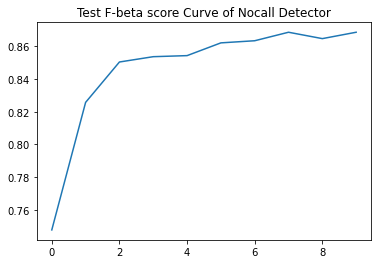

In [208]:
tfbeta_scores = torch.tensor(tfbeta_scores, device = 'cpu')
plt.plot(np.arange(len(tfbeta_scores)), tfbeta_scores)
plt.title('Test F-beta score Curve of Nocall Detector')

In [3]:
# 7번째 epoch 부터 validation accuracy 와 test accuracy가 엇갈리는 걸로 보아
# overfitting 이 일어나기 시작하는 것으로 보임

# evaluation of 6th epoch
# validation accuracy =  87.39% // test accuracy = 86.22%
# validation loss (log loss = 0.34, Fbeta = 0.87) // test loss (log loss = 0.36, Fbeta = 0.86)